In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


✅ RGB-D đã lưu tại: /content/drive/MyDrive/Khóa Luận/Data_Object/output_a/output_rgbd_2.npy
→ shape: (375, 1242, 4)


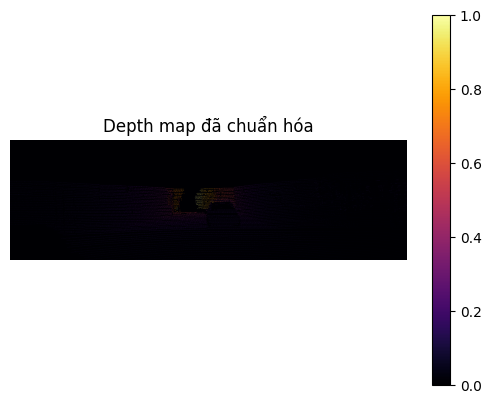

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -------- BƯỚC 1: Load dữ liệu từ .npz ------------
data = np.load("/content/drive/MyDrive/Khóa Luận/Data_Object/output_npz_training/000003_data.npz")
u = data["u"].astype(np.int32)
v = data["v"].astype(np.int32)
z = data["cam_xyz"][:, 2]  # Trục z đã căn chỉnh theo hệ tọa độ camera

# -------- BƯỚC 1.1: Load ảnh RGB tương ứng ------------
rgb = cv2.imread("/content/drive/MyDrive/Khóa Luận/Data_Object/training/image_2/000003.png", cv2.IMREAD_UNCHANGED)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

H, W = rgb.shape[:2]

# -------- BƯỚC 2: Tạo depth map theo (u, v) ------------
depth_map = np.zeros((H, W), dtype=np.float32)
count_map = np.zeros((H, W), dtype=np.int32)

for i in range(len(u)):
    ui, vi, zi = u[i], v[i], z[i]
    if 0 <= ui < W and 0 <= vi < H and zi > 0:
        depth_map[vi, ui] += zi
        count_map[vi, ui] += 1

mask = count_map > 0
depth_map[mask] /= count_map[mask]

# -------- BƯỚC 3: Chuẩn hóa depth để ghép vào RGB-D ------------
depth_clean = np.where(mask, depth_map, 0)
d_min = depth_clean[mask].min()
d_max = depth_clean[mask].max()

depth_normalized = np.zeros_like(depth_map)
depth_normalized[mask] = (depth_clean[mask] - d_min) / (d_max - d_min + 1e-6)
depth_uint8 = (depth_normalized * 255).astype(np.uint8)

# -------- BƯỚC 4: Gộp thành ảnh RGB-D (H, W, 4) ------------
rgbd = np.concatenate([rgb, depth_uint8[..., None]], axis=2)  # Shape (H, W, 4)

# -------- BƯỚC 5: Lưu ảnh RGB-D dưới dạng .npy ------------
out_npy_path = "/content/drive/MyDrive/Khóa Luận/Data_Object/output_a/output_rgbd_2.npy"
np.save(out_npy_path, rgbd)
print("✅ RGB-D đã lưu tại:", out_npy_path)
print("→ shape:", rgbd.shape)



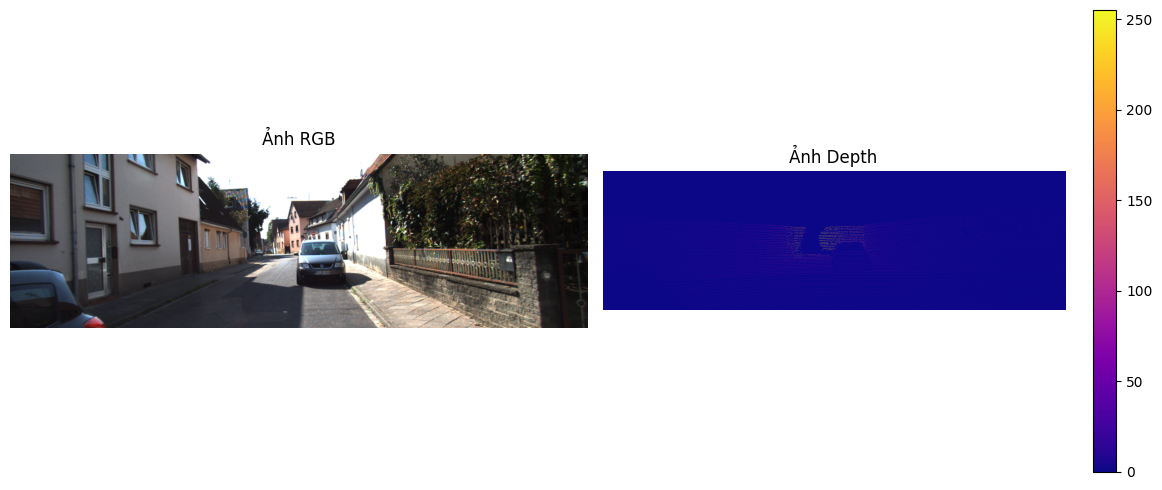

In [ ]:
# Tách RGB và Depth
rgb = rgbd[:, :, :3]
depth = rgbd[:, :, 3]

# Hiển thị RGB
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title("Ảnh RGB")
plt.axis('off')

# Hiển thị Depth
plt.subplot(1, 2, 2)
plt.imshow(depth, cmap='plasma')
plt.title("Ảnh Depth")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


**Chạy trên toàn bộ dataset**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_depth(depth, depth_interpolated, idx, output_dir):
    """Visualize Depth map trước và sau nội suy."""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Depth Map Thưa {idx}")
    plt.imshow(depth, cmap='jet')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title(f"Depth Map Sau Nội Suy {idx}")
    plt.imshow(depth_interpolated, cmap='jet')
    plt.colorbar()
    plt.savefig(f"{output_dir}/visualize_depth_{idx}.png")
    plt.close()

def create_rgbd_png(idx: str, output_dir: str):
    id_str = f"{int(idx):06d}"  # Đảm bảo đủ 6 chữ số
    rgb_path = f"/content/drive/MyDrive/Khóa Luận/Data_Object/testing/image_2/{id_str}.png"
    npz_path = f"/content/drive/MyDrive/Khóa Luận/Data_Object/output_npz_testing/{id_str}_data.npz"
    save_png_path = f"{output_dir}/output_rgbd_{id_str}.png"
    save_npy_path = f"{output_dir}/output_rgbd_{id_str}.npy"
    save_depth_png = f"{output_dir}/depth_{id_str}.png"

    # Kiểm tra file tồn tại
    if not os.path.exists(rgb_path) or not os.path.exists(npz_path):
        print(f"⏳ Thiếu file: {id_str}")
        return False

    # Đọc ảnh RGB
    rgb = cv2.imread(rgb_path, cv2.IMREAD_UNCHANGED)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  # Giữ [0, 255], uint8
    H, W = rgb.shape[:2]

    # Đọc dữ liệu Depth từ .npz
    data = np.load(npz_path)
    u = data["u"].astype(np.int32)
    v = data["v"].astype(np.int32)
    z = data["cam_xyz"][:, 2]

    # Tạo Depth map
    depth_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.uint8)

    for i in range(len(u)):
        ui, vi, zi = u[i], v[i], z[i]
        if 0 <= ui < W and 0 <= vi < H and zi > 0:
            depth_map[vi, ui] += zi
            count_map[vi, ui] += 1

    mask = count_map > 0
    if not np.any(mask):
        print(f"⚠️ Depth rỗng: {id_str}")
        return False

    # Kiểm tra mức độ thưa
    sparse_ratio = np.mean(count_map == 0)
    if sparse_ratio > 0.95:
        print(f"⚠️ Depth quá thưa: {id_str}, tỉ lệ thiếu {sparse_ratio*100:.2f}%")
        return False

    depth_map[mask] /= count_map[mask]
    depth_clean = np.where(mask, depth_map, 0)

    # Nội suy
    depth_clean = cv2.inpaint(depth_clean, (count_map == 0).astype(np.uint8), 5, cv2.INPUT_TELEA) # Sử dụng inpaint nâng cao hơn

    # Chuẩn hóa Depth
    d_min, d_max = depth_clean[mask].min(), depth_clean[mask].max()
    if d_max - d_min < 1e-3:
        print(f"⚠️ Depth không đủ đa dạng: {id_str}, d_min={d_min}, d_max={d_max}")
        return False

    depth_normalized = np.zeros_like(depth_map)
    depth_normalized[mask] = (depth_clean[mask] - d_min) / (d_max - d_min + 1e-6)
    depth_uint8 = (depth_normalized * 255).astype(np.uint8)


    # Lưu Depth map
    cv2.imwrite(save_depth_png, depth_uint8)
    print(f"✅ Saved Depth map: {save_depth_png}")

    # Ghép RGB và Depth
    rgbd = np.dstack((rgb, depth_uint8))  # RGB: [0, 255], Depth: [0, 255], uint8

    # Lưu .npy
    np.save(save_npy_path, rgbd.astype(np.uint8))
    print(f"✅ Saved RGB-D as NPY: {id_str} → {rgbd.shape}")

    # Lưu .png
    rgbd_bgr = cv2.cvtColor(rgbd, cv2.COLOR_RGBA2BGRA)
    cv2.imwrite(save_png_path, rgbd_bgr)
    print(f"✅ Saved RGB-D as PNG: {id_str}")

    return True

# Duyệt toàn bộ thư mục .npz
npz_folder = "/content/drive/MyDrive/Khóa Luận/Data_Object/output_npz_testing/"
npz_files = sorted([f for f in os.listdir(npz_folder) if f.endswith("_data.npz")])

output_dir = "/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/OutPut_Convert_to_RGB_D/testing/"
os.makedirs(output_dir, exist_ok=True)

for fname in npz_files:
    idx = fname.split("_")[0]
    try:
        create_rgbd_png(idx, output_dir)
    except Exception as e:
        print(f"❌ Lỗi {idx}: {e}")

In [ ]:
import os
import cv2
import numpy as np

def create_rgbd_png(idx: str):
    id_str = f"{int(idx):06d}"  # đảm bảo đủ 6 chữ số
    rgb_path = f"/content/drive/MyDrive/Khóa Luận/Data_Object/training/image_2/{id_str}.png"
    npz_path = f"/content/drive/MyDrive/Khóa Luận/Data_Object/output_npz_training/{id_str}_data.npz"
    save_png_path = f"/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/OutPut_Convert_to_RGB_D/training/output_rgbd_{id_str}.png"
    save_depth_png = f"/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/OutPut_Convert_to_RGB_D/training/depth_{id_str}.png"

    if not os.path.exists(rgb_path) or not os.path.exists(npz_path):
        print(f"⛔ Thiếu file: {id_str}")
        return False

    # Đọc ảnh RGB
    rgb = cv2.imread(rgb_path, cv2.IMREAD_UNCHANGED)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    H, W = rgb.shape[:2]

    # Đọc dữ liệu Depth từ .npz
    data = np.load(npz_path)
    u = data["u"].astype(np.int32)
    v = data["v"].astype(np.int32)
    z = data["cam_xyz"][:, 2]

    # Tạo Depth map
    depth_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.int32)

    for i in range(len(u)):
        ui, vi, zi = u[i], v[i], z[i]
        if 0 <= ui < W and 0 <= vi < H and zi > 0:
            depth_map[vi, ui] += zi
            count_map[vi, ui] += 1

    mask = count_map > 0
    if not np.any(mask):
        print(f"⚠️ Depth rỗng: {id_str}")
        return False

    depth_map[mask] /= count_map[mask]
    depth_clean = np.where(mask, depth_map, 0)

    # Nội một suy để lấp đầy lỗ hổng
    depth_clean = cv2.inpaint(depth_clean, (count_map == 0).astype(np.uint8), 3, cv2.INPAINT_NS)

    # Chuẩn hóa Depth
    d_min, d_max = depth_clean[mask].min(), depth_clean[mask].max()
    if d_max - d_min < 1e-3:
        print(f"⚠️ Depth không đủ đa dạng: {id_str}, d_min={d_min}, d_max={d_max}")
        return False

    depth_normalized = np.zeros_like(depth_map)
    depth_normalized[mask] = (depth_clean[mask] - d_min) / (d_max - d_min + 1e-6)
    depth_uint8 = (depth_normalized * 255).astype(np.uint8)

    # Lưu Depth map
    cv2.imwrite(save_depth_png, depth_uint8)
    print(f"✅ Depth map saved: {save_depth_png}")

    # Ghép RGB và Depth
    rgbd = np.dstack((rgb, depth_uint8))

    # Lưu .png
    rgbd_bgr = cv2.cvtColor(rgbd, cv2.COLOR_RGBA2BGRA)
    cv2.imwrite(save_png_path, rgbd_bgr)
    print(f"✅ RGB-D saved as PNG: {id_str} → {rgbd.shape}")

    return True

# Duyệt thư mục .npz từ idx = 006163
npz_folder = "/content/drive/MyDrive/Khóa Luận/Data_Object/output_npz_training/"
npz_files = sorted([f for f in os.listdir(npz_folder) if f.endswith("_data.npz")])

output_dir = "/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/OutPut_Convert_to_RGB_D/training/"
os.makedirs(output_dir, exist_ok=True)

start_idx = "006163"
for fname in npz_files:
    idx = fname.split("_")[0]
    if int(idx) < int(start_idx):  # Bỏ qua các file có idx < 006163
        continue
    try:
        create_rgbd_png(idx)
    except Exception as e:
        print(f"❌ Lỗi {idx}: {e}")

In [1]:
import os
import cv2
import numpy as np
import glob
from google.colab import drive


def create_depth_png(idx: str, input_dir: str, output_dir: str, max_depth: float = 100.0, inpaint: bool = True):
    """
    Tạo và lưu Depth map dưới dạng PNG 16-bit từ .npz, lấy kích thước từ ảnh RGB.

    Args:
        idx: ID file (e.g., "000003").
        input_dir: Thư mục chứa .npz và image_2.
        output_dir: Thư mục lưu Depth.png.
        max_depth: Độ sâu tối đa (meters) để scale PNG 16-bit.
        inpaint: Có nội suy vùng trống không.

    Returns:
        bool: True nếu thành công, False nếu lỗi.
    """
    id_str = f"{int(idx):06d}"
    npz_path = os.path.join(input_dir, "output_npz_training", f"{id_str}_data.npz")
    rgb_path = os.path.join(input_dir, "training","image_2", f"{id_str}.png")
    save_depth_path = os.path.join(output_dir, "depth", f"{id_str}.png")
    os.makedirs(os.path.dirname(save_depth_path), exist_ok=True)


    print(f"📂 Processing: {id_str}")
    print(f"📂 npz_path: {npz_path}")
    print(f"📂 rgb_path: {rgb_path}")
    print(f"📂 save_depth_path: {save_depth_path}")

    # Lấy kích thước từ RGB
    rgb = cv2.imread(rgb_path, cv2.IMREAD_UNCHANGED)
    if rgb is None:
        print(f"❌ Không đọc được RGB: {rgb_path}")
        return False
    H, W = rgb.shape[:2]
    print(f"📏 Image size: H={H}, W={W}")

    # Đọc .npz
    try:
        data = np.load(npz_path)
        u = data["u"].astype(np.int32)
        v = data["v"].astype(np.int32)
        z = data["cam_xyz"][:, 2]  # Độ sâu (meters)
    except Exception as e:
        print(f"❌ Lỗi đọc .npz {id_str}: {e}")
        return False

    # Vector hóa tạo Depth map
    valid = (0 <= u) & (u < W) & (0 <= v) & (v < H) & (z > 0)
    u, v, z = u[valid], v[valid], z[valid]
    if len(z) == 0:
        print(f"⚠️ Depth rỗng: {id_str}")
        return False
    print(f"📊 Valid points: {len(z)}")

    depth_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.int32)
    np.add.at(depth_map, (v, u), z)
    np.add.at(count_map, (v, u), 1)

    mask = count_map > 0
    depth_map[mask] /= count_map[mask]

    # Nội suy
    if inpaint:
        depth_map = cv2.inpaint(depth_map, (~mask).astype(np.uint8), 5, cv2.INPAINT_TELEA)

    # Lưu PNG 16-bit
    depth_scaled = (depth_map / max_depth * 65535).clip(0, 65535).astype(np.uint16)
    if not cv2.imwrite(save_depth_path, depth_scaled):
        print(f"❌ Lỗi khi lưu Depth PNG: {save_depth_path}")
        return False

    # Kiểm tra file đã lưu
    if os.path.exists(save_depth_path):
        print(f"✅ Saved Depth PNG: {save_depth_path}")
        print(f"📏 File size: {os.path.getsize(save_depth_path)} bytes")
        return True
    else:
        print(f"❌ File không được lưu: {save_depth_path}")
        return False

def preprocess_kitti(input_dir: str, output_dir: str, max_depth: float = 100.0):
    """Xử lý toàn bộ dataset."""
    npz_files = sorted(glob.glob(os.path.join(input_dir, "output_npz_training", "*_data.npz")))
    if not npz_files:
        print(f"❌ Không tìm thấy file .npz trong: {os.path.join(input_dir, 'output_npz_training')}")
        return

    print(f"📂 Found {len(npz_files)} .npz files")
    for npz_path in npz_files:
        idx = os.path.basename(npz_path).split("_")[0]
        print(f"🔄 Processing idx: {idx}")
        try:
            create_depth_png(idx, input_dir, output_dir, max_depth=max_depth)
        except Exception as e:
            print(f"❌ Lỗi {idx}: {e}")


# Chạy pipeline
input_dir = "/content/drive/MyDrive/Khóa Luận/Data_Object/"
output_dir = "/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/OutPut_Convert_to_RGB_D_3/training/"

# Kiểm tra max_depth
preprocess_kitti(input_dir, output_dir, max_depth=100.0)

Streaming output truncated to the last 5000 lines.
📂 save_depth_path: /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/OutPut_Convert_to_RGB_D_3/training/depth/006925.png
📏 Image size: H=374, W=1238
📊 Valid points: 17839
✅ Saved Depth PNG: /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/OutPut_Convert_to_RGB_D_3/training/depth/006925.png
📏 File size: 778105 bytes
🔄 Processing idx: 006926
📂 Processing: 006926
📂 npz_path: /content/drive/MyDrive/Khóa Luận/Data_Object/output_npz_training/006926_data.npz
📂 rgb_path: /content/drive/MyDrive/Khóa Luận/Data_Object/training/image_2/006926.png
📂 save_depth_path: /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/OutPut_Convert_to_RGB_D_3/training/depth/006926.png
📏 Image size: H=375, W=1242
📊 Valid points: 19063
✅ Saved Depth PNG: /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/OutPut_Convert_to_RGB_D_3/training/depth/006926.p